In [1]:
cd ~/Desktop/DeepLearningPilot/

/Users/jz-rolling/Desktop/DeepLearningPilot


In [80]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from skimage import filters,morphology
from scipy.stats import pearsonr
import seaborn as sns
from ncolor import label
from timeit import default_timer
import pickle as pk, glob, os
import momia2 as mo
from ncolor import label
from matplotlib import cm
from scipy.stats import skew,kurtosis

In [3]:
sample_dict = {}
for i in range(1,6):
    for j,k in enumerate(sorted(glob.glob('/Volumes/JZSSD_temp/20190709_NQTF/pred_results/{}_*tracker.pk'.format(i)))):
        header = k.split('_tracker.pk')[0]
        phase = np.load(header+'_clips.npy')
        masks = np.load(header+'_omni_masks.npy')
        fitc = np.load(header+'_fitc.npy')
        merged_rp = pk.load(open(k,'rb'))
        sample_dict['{}_{}'.format(i,j)] = [phase,fitc,merged_rp,k,masks]

/Volumes/JZSSD_temp/20190709_NQTF/pred_results/1_0083-0336-1354_tracker.pk
/Volumes/JZSSD_temp/20190709_NQTF/pred_results/1_0083-0386-0830_tracker.pk
/Volumes/JZSSD_temp/20190709_NQTF/pred_results/1_0083-0595-1481_tracker.pk
/Volumes/JZSSD_temp/20190709_NQTF/pred_results/1_0083-1180-0559_tracker.pk
/Volumes/JZSSD_temp/20190709_NQTF/pred_results/1_0083-1192-0888_tracker.pk
/Volumes/JZSSD_temp/20190709_NQTF/pred_results/1_0083-1544-0699_tracker.pk
/Volumes/JZSSD_temp/20190709_NQTF/pred_results/1_0083-1560-1187_tracker.pk
/Volumes/JZSSD_temp/20190709_NQTF/pred_results/1_0151-0180-0354_tracker.pk
/Volumes/JZSSD_temp/20190709_NQTF/pred_results/1_0151-0521-0528_tracker.pk
/Volumes/JZSSD_temp/20190709_NQTF/pred_results/2_0067-0589-0532_tracker.pk
/Volumes/JZSSD_temp/20190709_NQTF/pred_results/2_0067-0636-1052_tracker.pk
/Volumes/JZSSD_temp/20190709_NQTF/pred_results/2_0067-0917-0809_tracker.pk
/Volumes/JZSSD_temp/20190709_NQTF/pred_results/2_0067-1148-1092_tracker.pk
/Volumes/JZSSD_temp/20190

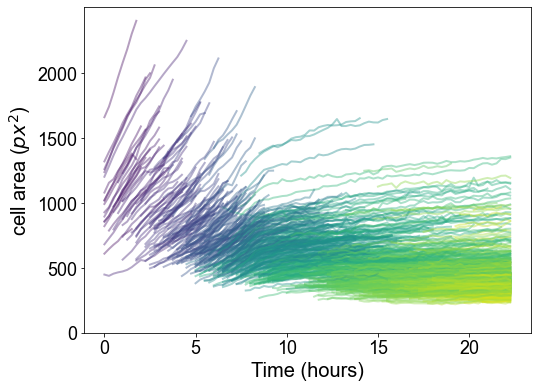

In [87]:
filtered_df = []
fig=plt.figure(figsize=(8,6))
ax = fig.add_subplot()
for k,m in sample_dict.items():
    merged_rp=m[2]
    fitc = m[1]
    for c in merged_rp['cell_lineage'].unique():
        subset = merged_rp[merged_rp['cell_lineage']==c].copy()
        cond1 = subset['aspect_ratio'].max()<0.8
        cond2 = subset['area'].min()>200
        cond2 = subset['area'].min()>200
        cond3 = subset['area'].max()<2500
        cond4 = subset['$touching_edge'].max()==0
        cond5 = len(subset)>6
        cond6 = False
        cond7 = ((subset['area'].max()-subset['area'].mean())>200) | (subset['area'].min()<1500)
        if cond5:
            v = subset['area'].values
            if (np.abs(v[1:]-v[:-1])/v[:-1]).max()<0.08:
                cond6 = True
        composite_cond = cond1*cond2*cond3*cond4*cond5*cond6*cond7
        if composite_cond:
            subset['ROI'] = k
            fitc_stat = []
            for coords,time in subset[['$coords','$time']].values:
                croped_fitc = fitc[time,coords[:,0],coords[:,1]]
                fitc_stat.append([croped_fitc.min(),
                                  croped_fitc.max(),
                                  croped_fitc.mean(),
                                  np.median(croped_fitc),
                                  skew(croped_fitc),
                                  kurtosis(croped_fitc)])
            subset[['FITC_min','FITC_max','FITC_mean','FITC_median','FITC_skewness','FITC_kurtosis']]=fitc_stat
            filtered_df.append(subset)
            ax.plot(subset['$time'].values,subset['area'].values,alpha=0.4,
                     color=cm.get_cmap('viridis')(subset['$time'].values.mean()/90),
                     lw=2)
ax.set_xticks([0,20,40,60,80])
ax.set_xticklabels([0,5,10,15,20],fontsize=18,fontname='Arial')
ax.set_yticks([0,500,1000,1500,2000])
ax.set_yticklabels([0,500,1000,1500,2000],fontsize=18,fontname='Arial')
ax.set_xlabel('Time (hours)',fontsize=20,fontname='Arial')
ax.set_ylabel('cell area ($px^2$)',fontsize=20,fontname='Arial')
filtered_df = pd.concat(filtered_df)
filtered_df['Group'] = np.round(filtered_df['$time'].values/4,0)
pk.dump(filtered_df,open('/Volumes/JZSSD_temp/20190709_NQTF/2_tracking_plots/EMB_pooled.pk','wb'))
plt.savefig('/Volumes/JZSSD_temp/20190709_NQTF/2_tracking_plots/EMB_track.png',dpi=160,bbox_inches='tight')

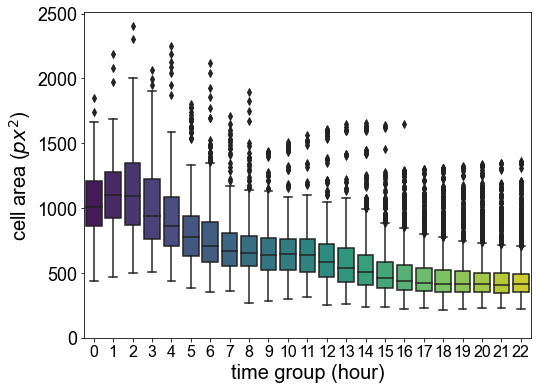

In [79]:
# now we group by time 
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot()
g = sns.boxplot(data=filtered_df,x='Group',y='area',palette='viridis',ax=ax)
ax.set_xticks(np.arange(23))
ax.set_xticklabels(np.arange(23),fontsize=16,fontname='Arial')
ax.set_yticks([0,500,1000,1500,2000,2500])
ax.set_yticklabels([0,500,1000,1500,2000,2500],fontsize=18,fontname='Arial')
ax.set_xlabel('time group (hour)',fontsize=20,fontname='Arial')
ax.set_ylabel('cell area ($px^2$)',fontsize=20,fontname='Arial')
plt.savefig('/Volumes/JZSSD_temp/20190709_NQTF/2_tracking_plots/EMB_grouped_size.png',dpi=160,bbox_inches='tight')

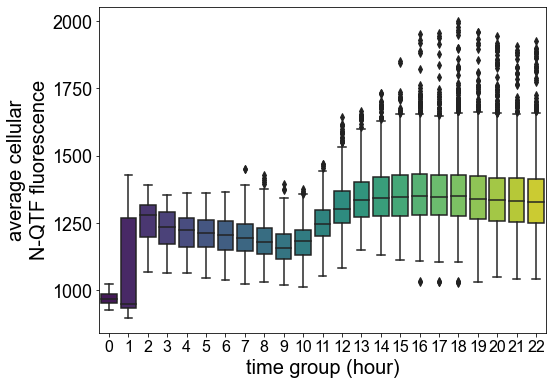

In [93]:
# now we group by time 
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot()
g = sns.boxplot(data=filtered_df,x='Group',y='FITC_mean',palette='viridis',ax=ax)
ax.set_xticks(np.arange(23))
ax.set_xticklabels(np.arange(23),fontsize=16,fontname='Arial')
ax.set_yticks([1000,1250,1500,1750,2000])
ax.set_yticklabels([1000,1250,1500,1750,2000],fontsize=18,fontname='Arial')
ax.set_xlabel('time group (hour)',fontsize=20,fontname='Arial')
ax.set_ylabel('average cellular\nN-QTF fluorescence',fontsize=20,fontname='Arial')
plt.savefig('/Volumes/JZSSD_temp/20190709_NQTF/2_tracking_plots/EMB_grouped_fluorescence.png',dpi=160,bbox_inches='tight')

In [115]:
for k,m in sample_dict.items():
    folder = '/Volumes/JZSSD_temp/20190709_NQTF/trace_plot/{}/'.format(k)
    if not os.path.isdir(folder):
        os.mkdir(folder)
    merged_rp=m[2]
    unique_cells = merged_rp['cell_lineage'].unique()
    count_dict = {}
    for x in unique_cells:
        rid = x.split('.')[0]
        if not rid in count_dict:
            count_dict[rid]=1
        else:
            count_dict[rid]+=1
    #filter count
    color_count = 0
    color_dict = {}
    for i,(ac,count) in enumerate(count_dict.items()):
        if count>2:
            color_dict[ac]=cm.get_cmap('tab20')(color_count)
            color_count+=1

    for t in merged_rp['$time'].unique():
        #img=label(tracker_msm.frames[t].labeled_mask)
        img = m[0][t+5]
        h,w = img.shape
        fig=plt.figure(figsize=(w/50,h/50))
        plt.imshow(img,cmap='gist_gray')
        subset = merged_rp[merged_rp['$time']==t].copy()
        for l in subset['cell_lineage'].unique():
            anc = l.split('.')[0]
            if anc in color_dict:
                color=color_dict[anc]
                cell = subset[subset['cell_lineage']==l].copy()
                for c in cell.index:
                    x1,y1,contours,touching_edge = cell.loc[c,['$opt-x1','$opt-y1','$refined_contours','$touching_edge']].values
                    if len(contours)>0:
                        if len(contours[0])>10:
                            #contours = [mo.utils.contour.contour_moving_window_smoothing(contours[0])]
                            #simp_contour=mo.core.patch.approximate_polygon(contour,tolerance=0.5)
                            xc,yc = contours[0].T
                            xc = xc+x1
                            yc = yc+y1
                            plt.fill(yc,xc,fc=color,ec=None,alpha=0.4)
                            plt.plot(yc,xc,color=color,lw=1.5,alpha=1)
        plt.axis('off')
        plt.savefig('{}{}.png'.format(folder,t+5),bbox_inches='tight')
        plt.close()

In [34]:
import cv2
import numpy as np
import glob


for f in sorted(glob.glob("/Volumes/LaCie2/phage_lsr2_cellview/*/")):
    header = f.split('/')[-2]
    frames = []
    
    for i in range(t1,t2+1):
        p = f+'{}.png'.format(i)
        img = cv2.imread(p)
        height, width, _c = img.shape
        frames.append(img)
        fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
        out2 = cv2.VideoWriter('/Volumes/LaCie2/phage_lsr2_movies/{}.avi'.format(header),
                               fourcc, fps=3, frameSize=np.flip(img.shape[:2]))
    for i in range(len(frames)):
        out2.write(frames[i])
    out2.release()

'1_0'

In [7]:
for k in sorted(glob.glob('/Volumes/JZSSD_temp/20190709_NQTF/pred_results/*_clips.npy')):
    header = k.split('_clips.npy')[0]
    if not os.path.isfile(header+'_tracker.pk'):
        images = np.load(k)
        mask = np.load(header+'_omni_masks.npy')
        flow = np.load(header+'_omni_flows.npy',allow_pickle=True)
        frames=[]
        for i in range(5,60):
            p=mo.Patch()
            p.load_data(i,{'C1':images[i]},
                            ref_channel='C1')
            labeled_mask = morphology.remove_small_objects(mask[i],50)
            p.mask = labeled_mask>0
            p.labeled_mask = labeled_mask
            h,w = labeled_mask.shape
            prob_mask = np.zeros([h,w,3])
            prob_mask[:,:,2] = mo.classify.classifier_helper.normalize_image(flow[i][2],min_perc=0.01,max_perc=100,max_v=None,min_v=None)
            prob_mask[:,:,0] = 1-p.mask
            p.prob_mask = prob_mask
            p.locate_particles(precompute_contours=False)
            #p.extract_midlines(contour_key='$contours')
            frames.append(p)


        tracker_msm = mo.core.CellTracker(frames,np.arange(len(frames)),
                                          None,
                                          verbose=False,
                                          seed_prob_min=0.7,
                                          max_iter=5,
                                          min_cell_size=50,
                                          min_overlap_area=80,
                                          backtrack_generations=5,
                                          min_overlap_threshold=0.3,
                                          min_size_similarity=0.7,
                                          no_split=False,hard_split=True)
        break

In [8]:
tracker_msm.link_cells()
for i in range(1):
    tracker_msm.refine_trace()
    tracker_msm.link_cells()
    tracker_msm.trace_lineage()
for p in tracker_msm.frames:
    p.locate_particles(precompute_contours=True)
    p.refine_contours(update_mask=False,approximate=False,step_range=(-1.5,0.5),n_steps=10,
                      smoothing='moving_window',
                      verbose=False)
    p.extract_midlines(tol=0.2)
tracker_msm.link_cells()
tracker_msm.trace_lineage()

/Users/jz-rolling/opt/anaconda3/envs/keras_pilot/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/jz-rolling/opt/anaconda3/envs/keras_pilot/lib/python3.8/site-packages/numpy/lib/function_base.py:334: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  m = asarray(m)


Rectification failed for cell 11_11.
Rectification failed for cell 14_14.
Rectification failed for cell 15_15.
Rectification failed for cell 18_16.
Rectification failed for cell 18_2.
Rectification failed for cell 44_26.
Rectification failed for cell 45_26.


/Users/jz-rolling/opt/anaconda3/envs/keras_pilot/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/jz-rolling/opt/anaconda3/envs/keras_pilot/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


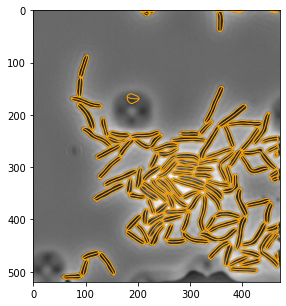

In [ ]:
for p in tracker_msm.frames:
    p.extract_midlines()

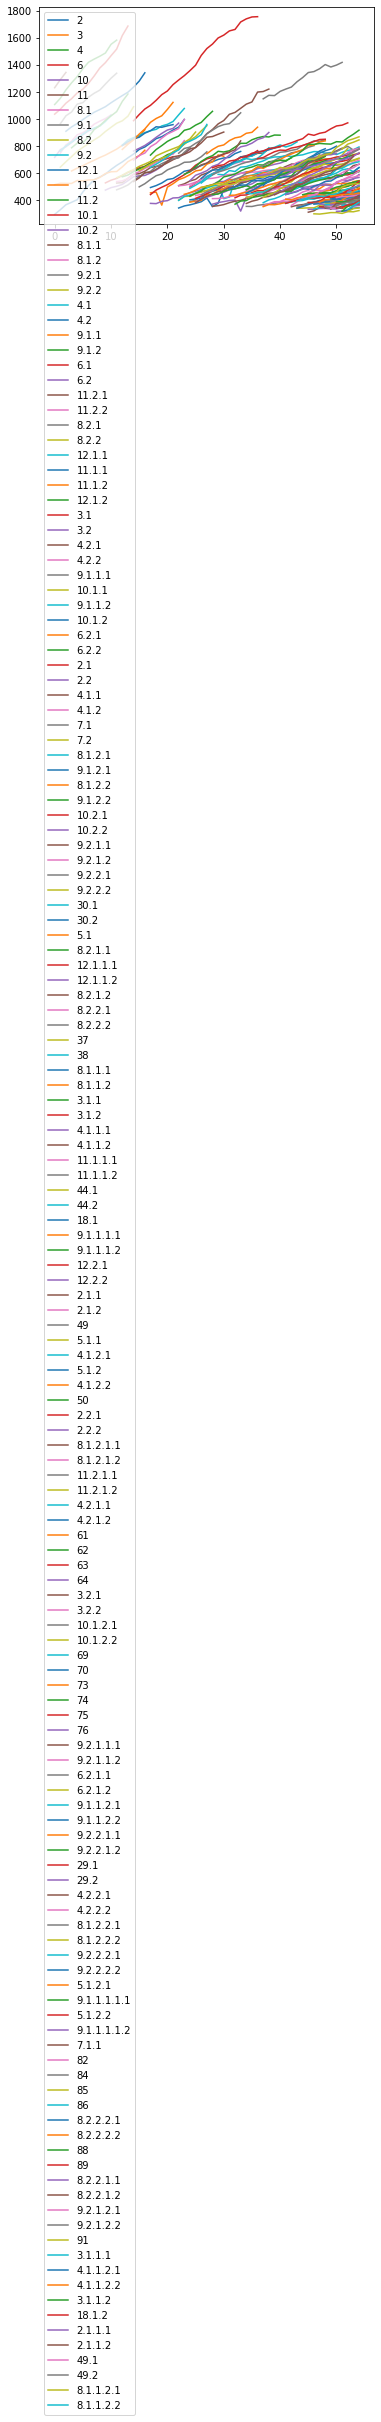

In [48]:
merged_rp = tracker_msm.regionprops
for c in merged_rp['cell_lineage'].unique():
    subset = merged_rp[merged_rp['cell_lineage']==c]
    if subset['aspect_ratio'].max()<0.9:
        v=subset['area'].values
        if len(v)>2 and subset['$touching_edge'].max()==0:
            plt.plot(subset['$time'],v,label=c)
plt.legend()

In [15]:
for p in tracker_msm.frames:
    #p.locate_particles(precompute_contours=True,contour_kwargs={'level':0.1, 'dilation':True})
    p.refine_contours(update_mask=False,approximate=False,step_range=(-2,0),n_steps=10,
                      smoothing='moving_window',
                      verbose=False)
tracker_msm.link_cells()
tracker_msm.trace_lineage()

/Users/jz-rolling/opt/anaconda3/envs/keras_pilot/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


In [12]:
merged_rp=tracker_msm.regionprops
for t in merged_rp['$time'].unique():
    #img=label(tracker_msm.frames[t].labeled_mask)
    img = tracker_msm.frames[t].get_ref_image()
    h,w = img.shape
    fig=plt.figure(figsize=(w/50,h/50))
    plt.imshow(img,cmap='gist_gray')
    subset = merged_rp[merged_rp['$time']==t].copy()
    for l in subset['cell_lineage'].unique():
        if l.startswith('10.') or l=='10':
            cell = subset[subset['cell_lineage']==l].copy()
            for c in cell.index:
                x1,y1,contours,touching_edge = cell.loc[c,['$opt-x1','$opt-y1','$refined_contours','$touching_edge']].values
                if len(contours[0])>10:
                    #contours = [mo.utils.contour.contour_moving_window_smoothing(contours[0])]
                    #simp_contour=mo.core.patch.approximate_polygon(contour,tolerance=0.5)
                    xc,yc = contours[0].T
                    xc = xc+x1
                    yc = yc+y1
                    plt.plot(yc,xc,color='r')
    plt.axis('off')
    plt.savefig('/Volumes/JZSSD_temp/20190709_NQTF/trace_plot/test/{}.png'.format(t+5),bbox_inches='tight')
    plt.close()
    #break

In [10]:
linking_matrix,trans_matrix,overlap_stat,labels1,labels2= silly_link(tracker_msm,2)


In [117]:
list(sample_dict.keys())

['1_0',
 '1_1',
 '1_2',
 '1_3',
 '1_4',
 '1_5',
 '1_6',
 '1_7',
 '1_8',
 '2_0',
 '2_1',
 '2_2',
 '2_3',
 '2_4',
 '2_5',
 '2_6',
 '2_7',
 '3_0',
 '3_1',
 '3_2',
 '3_3',
 '3_4',
 '4_0',
 '4_1',
 '4_2']

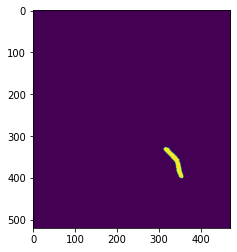

In [42]:
plt.imshow((tracker_msm.frames[16].labeled_mask==labels1[14])+(tracker_msm.frames[17].labeled_mask==labels2[16]))

In [34]:
np.where(linking_matrix.sum(axis=1)==0)

(array([32, 94]),)

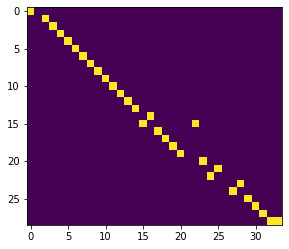

In [29]:
plt.imshow(linking_matrix)

In [11]:
from momia2.core.tracker import *
import timeit

In [14]:
linking_matrix,trans_matrix,overlap_stat,labels1,labels2=silly_link(tracker_msm,49)

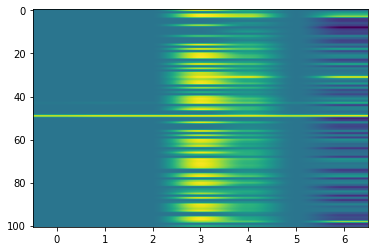

In [29]:
plt.imshow(trans_matrix[49],aspect='auto')

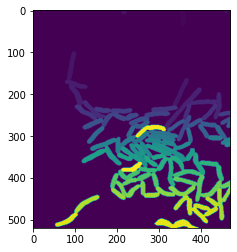

In [30]:
plt.imshow(tracker_msm.frames[50].labeled_mask)

In [202]:
%timeit x= l2_1_coords[:,np.newaxis,:]-l2_2_coords[np.newaxis,:,:]

303 µs ± 13.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


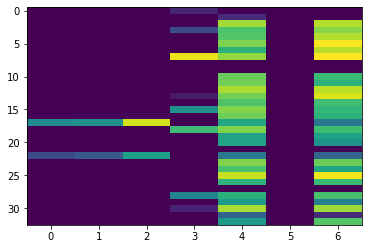

In [118]:
for i in f1_remnant:
        
    f1_area = f1.regionprops.loc[labels1[i],'area'].sum()
        f2_list = list(np.where(linking_matrix[i]>0)[0])
        top_daughters = list(np.flip(np.argsort(np.sum(np.log2(trans_matrix[i,:,np.array([0,1,2,5])]+1),axis=0)))[:4])
        top_daughters = [-1]+top_daughters
        for j in top_daughters:
            if j not in f2_list and trans_matrix[:,j].sum()==0 and j!=-1:
                if len(f2_list)==0:
                    f2_list.append(j)
                else:
                    j_neighbors = [f2n['{}_{}'.format(t+1,int(x))] for x in np.unique(np.concatenate([_get_neighbors(f2.labeled_mask,labels2[k]) for k in f2_list]))]
                    if j in j_neighbors:
                        f2_list.append(j) 
                if len(f2_list)>0:
                    f2_area = f2.regionprops.loc[labels2[np.array(f2_list)],'area'].sum()
                    if np.abs(2*(f1_area-f2_area)/(f1_area+f2_area)) < diff_threshold:
                        matched_l1[i]=1
                        matched_l2[np.array(f2_list)]=1
                        linking_matrix[i,np.array(f2_list)]=1
                        break
                    elif f2_area>f1_area:
                        f2_list.pop()




In [265]:
log_prob_matrix[16,16]

4.9069186341678215

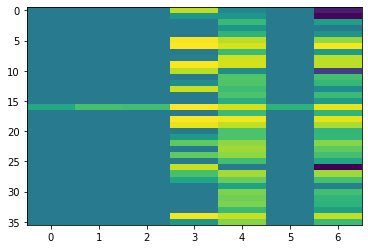

In [262]:
plt.imshow(trans_matrix[:,16],aspect='auto')

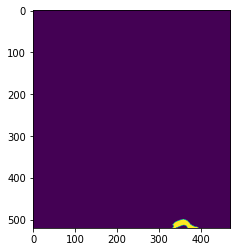

In [271]:
plt.imshow(f2.labeled_mask==labels2[36])

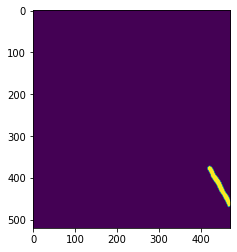

In [273]:
plt.imshow(f1.labeled_mask==labels1[29])

In [66]:
linking_matrix,trans_matrix,overlap_stat,labels1,labels2=silly_link(tracker_msm,49)

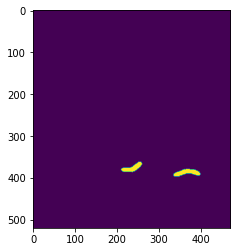

In [56]:
plt.imshow((tracker_msm.frames[49].labeled_mask==labels1[68])+(tracker_msm.frames[50].labeled_mask==labels2[100]))

In [68]:
np.where(linking_matrix.sum(axis=0)==0)

(array([], dtype=int64),)

In [ ]:
masks = 
mo.core.tracker.silly_link()